In [1]:
using Printf, JLD2
include("../code/headers.jl")

# BP with decimation

In [2]:
function performance(fg::FactorGraph, fields, σ=ones(Int,fg.n), x=falses(fg.n))
    σ .= sign.(fg.fields)
    x .= σ .== -1
    nunsat = parity(fg, x)
    dist = distortion(fg, fields, σ)
    ovl = 1-2*dist
    nunsat, ovl, dist
end

performance (generic function with 4 methods)

In [3]:
function decimate1!(fg, fields, freevars; ndec=1, maxiter=200, F=1.0, verbose=true, tol=1e-12)
    ε = 0.0
    iters = 0
    for f in 1:m; fg.mfv[f] .= zeros(length(fg.mfv[f])) end
    fg.fields .= copy(fields)  
    # pre-allocate for speed
    fact_perm = randperm(fg.m); σ=ones(Int, fg.n); x=falses(fg.n)
    for it in 1:maxiter
        ε = onebpiter!(fg, BP(); fact_perm=fact_perm) 
        if ε==-1
            return -2, NaN, NaN, it
        end
        if ε < tol; (iters = it; break) else; iters=maxiter end 
        shuffle!(fact_perm)
    end
    nunsat, ovl, dist = performance(fg, fields, σ, x)
    if verbose 
        @printf(" Step   0. Free = %3d. ε = %6.2E. Unsat = %3d. Ovl = %.3f. Iters %d\n", 
            length(freevars), ε, nunsat,  ovl, iters)
    end
    cnt = 1
    iters = 0
    while !isempty(freevars)
        sort!(freevars, by=j->abs(fg.fields[j]))
        freevars, tofix = freevars[1:end-ndec], freevars[max(1,end-ndec+1):end]
        for tf in tofix; fg.fields[tf] == 0 && (fg.fields[tf] = fields[tf]) end
        fg.fields[tofix] .= F*sign.(fg.fields[tofix])
        for it in 1:maxiter
            ε = onebpiter!(fg, BP(); fact_perm=fact_perm)
            ε == -1.0 && return -1, NaN, NaN, it   # when a contradiction is found
            if ε < tol; (iters = it; break) else; iters=maxiter end 
            shuffle!(fact_perm)
        end
        nunsat, ovl, dist = performance(fg, fields, σ, x)
        if verbose 
            @printf(" Step %3d. Fixing %6s. Free = %3d. ε = %6.2E. Unsat = %3d. Ovl = %.3f. Iters %d\n", 
                cnt, string(tofix), length(freevars), ε, nunsat,  ovl, iters)
        end
        nunsat == 0 && return nunsat, ovl, dist, iters
        cnt += 1
    end
    nunsat, ovl, dist, iters
end

decimate1! (generic function with 1 method)

In [16]:
function decimate!(fg, fields, free=collect(1:fg.n); Tmax=1, kw...)
    freevars = copy(free)
    for t in 1:Tmax
        freevars .= copy(free)
        nunsat, ovl, dist, iters = decimate1!(fg, fields, freevars; kw...)
        str = "$nunsat unsat"
        nunsat==-1 && (str="contradiction found after $iters iters")
        nunsat==-2 && (str="contradiction found already in the first BP run before decimation, after $iters iters")
        print("# Trial $t of $Tmax: ", str)
        if nunsat == 0 
            if all(sign.(fg.fields) .!= 0)
                println()
                return nunsat, ovl, dist
            else
               print(" but ", sum(sign.(fg.fields).==0), " undecided") 
            end
        end
        println()
    end
    println("No zero-unsat found after $Tmax trials")
    return -1, NaN, NaN
end

decimate! (generic function with 2 methods)

## 1. Variables of degree 2

In [182]:
n = 1000
R = 0.3
m = round(Int,n*(1-R))
fg = ldpc_graphGF2(n,m)
H = 1e-5
src = rand((-1,1), n)
fields = tanh.(H*src)
fg.fields .= fields
basis, indep = lightbasis(fg)
freevars = findall(indep);

In [183]:
nunsat, ovl, dist = decimate!(fg, fields, freevars, maxiter=3000, verbose=true, F=1, Tmax=5) 

 Step   0. Free = 300. ε = 1.00E-15. Unsat = 267. Ovl = 0.916. Iters 5
 Step   1. Free = 299. ε = 1.00E-15. Unsat = 267. Ovl = 0.916. Iters 4
 Step   2. Free = 298. ε = 1.00E-15. Unsat = 267. Ovl = 0.916. Iters 3
 Step   3. Free = 297. ε = 1.00E-15. Unsat = 267. Ovl = 0.916. Iters 4
 Step   4. Free = 296. ε = 1.00E-15. Unsat = 267. Ovl = 0.916. Iters 3
 Step   5. Free = 295. ε = 2.00E-20. Unsat = 265. Ovl = 0.914. Iters 4
 Step   6. Free = 294. ε = 2.00E-15. Unsat = 265. Ovl = 0.914. Iters 4
 Step   7. Free = 293. ε = 2.00E-15. Unsat = 265. Ovl = 0.914. Iters 3
 Step   8. Free = 292. ε = 2.00E-20. Unsat = 265. Ovl = 0.914. Iters 3
 Step   9. Free = 291. ε = 1.00E-15. Unsat = 265. Ovl = 0.914. Iters 4
 Step  10. Free = 290. ε = 1.00E-15. Unsat = 265. Ovl = 0.912. Iters 4
 Step  11. Free = 289. ε = 1.02E-20. Unsat = 263. Ovl = 0.910. Iters 4
 Step  12. Free = 288. ε = 1.02E-20. Unsat = 261. Ovl = 0.908. Iters 5
 Step  13. Free = 287. ε = 1.00E-15. Unsat = 261. Ovl = 0.908. Iters 4
 Step 

 Step 161. Free = 139. ε = 3.00E-15. Unsat = 135. Ovl = 0.712. Iters 4
 Step 162. Free = 138. ε = 4.00E-15. Unsat = 135. Ovl = 0.710. Iters 5
 Step 163. Free = 137. ε = 1.00E-15. Unsat = 135. Ovl = 0.710. Iters 3
 Step 164. Free = 136. ε = 1.00E-15. Unsat = 133. Ovl = 0.708. Iters 3
 Step 165. Free = 135. ε = 3.00E-15. Unsat = 133. Ovl = 0.708. Iters 3
 Step 166. Free = 134. ε = 5.00E-15. Unsat = 131. Ovl = 0.706. Iters 7
 Step 167. Free = 133. ε = 3.00E-15. Unsat = 129. Ovl = 0.704. Iters 5
 Step 168. Free = 132. ε = 1.00E-15. Unsat = 125. Ovl = 0.700. Iters 7
 Step 169. Free = 131. ε = 1.00E-15. Unsat = 125. Ovl = 0.700. Iters 5
 Step 170. Free = 130. ε = 2.00E-15. Unsat = 125. Ovl = 0.698. Iters 6
 Step 171. Free = 129. ε = 2.00E-15. Unsat = 125. Ovl = 0.698. Iters 5
 Step 172. Free = 128. ε = 2.00E-15. Unsat = 125. Ovl = 0.698. Iters 4
 Step 173. Free = 127. ε = 3.00E-15. Unsat = 123. Ovl = 0.694. Iters 4
 Step 174. Free = 126. ε = 1.00E-15. Unsat = 123. Ovl = 0.694. Iters 5
 Step 

(0, 0.538, 0.231)

In [184]:
lm = LossyModel(fg, y=(src.==-1))
res = solve!(lm, OptimalCycle())
dist_oc = res.distortion

Iter 1. Distortion 0.226. Cycle weight -564.0. Energy shift -282.0
Iter 2. Distortion 0.226. Cycle weight 0.0. Energy shift 0.0


0.226

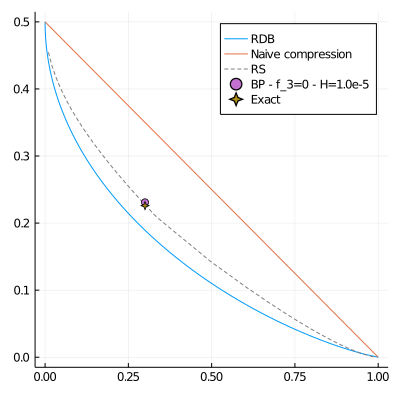

In [185]:
pl = plot_rdb()
scatter!([R], [dist], label="BP - f_3=0 - H=$H")
scatter!([R], [dist_oc], label="Exact", marker=:star4)
plot(pl, size=(400,400))

### 1.1 Varying H

In [155]:
n = 1000
R = 0.3
r = 1-3R
m = round(Int,n*(1-R))
Hs = 10.0 .^ (-2:0.5:0.5)
navg = 1
dist_f2 = [zeros(navg) for _ in eachindex(Hs)]
dist_oc_f2 = zeros(navg)
for j in 1:navg
    println("### Round $j of $navg ###")
    fg = ldpc_graphGF2(n,m)
    _, indep = lightbasis(fg)
    freevars = findall(indep)
    s = rand((-1,1), n)
    for (i,H) in enumerate(Hs)
        println("------ H=", H, ". ", i, " of ", length(Hs), " ------")
        fields = tanh.(H*copy(s))
        _,_,d = decimate!(fg, fields, freevars, maxiter=100, verbose=false, Tmax=1) 
        dist_f2[i][j] = d
    end
    lm = LossyModel(fg, y=(s.==-1))
    res = solve!(lm, OptimalCycle(), verbose=false)
    dist_oc_f2[j] = res.distortion
end

### Round 1 of 1 ###
------ H=0.01. 1 of 6 ------
# Trial 1 of 1: 0 unsat
------ H=0.03162277660168379. 2 of 6 ------
# Trial 1 of 1: 0 unsat
------ H=0.1. 3 of 6 ------
# Trial 1 of 1: 0 unsat
------ H=0.31622776601683794. 4 of 6 ------
# Trial 1 of 1: 0 unsat
------ H=1.0. 5 of 6 ------
# Trial 1 of 1: contradiction found already in the first BP run before decimation, after 68 iters
No zero-unsat found after 1 trials
------ H=3.1622776601683795. 6 of 6 ------
# Trial 1 of 1: contradiction found already in the first BP run before decimation, after 9 iters
No zero-unsat found after 1 trials


Average over 1 instances


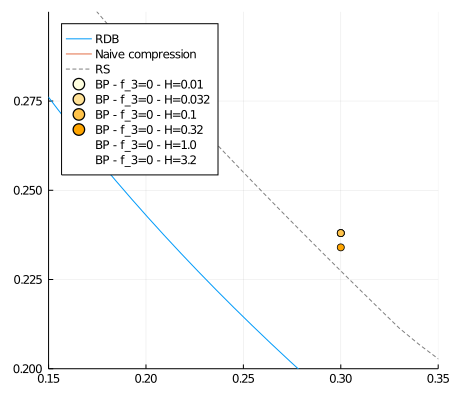

In [156]:
println("Average over $navg instances")
colors = cgrad(:heat, length(Hs)+1, categorical = true)
pl_f2 = plot_rdb()
for (i,H) in enumerate(Hs)
    scatter!(pl_f2, [R], [mean(dist_f2[i][.!isnan.(dist_f2[i])])], label="BP - f_3=0 - H=$(round(H,sigdigits=2))", 
        mc=colors[i])
end
# scatter!(pl_f2, [R], [mean(dist_oc_f2)], label="Exact - f_3=0", marker=:star4)
plot(pl_f2, size=(450,400), legend=:topleft)
xlims!((0.15,0.35)); ylims!((0.2,0.3))

In [157]:
[Hs dist_f2]

6×2 Array{Any,2}:
 0.01       [0.238]
 0.0316228  [0.238]
 0.1        [0.238]
 0.316228   [0.234]
 1.0        [NaN]
 3.16228    [NaN]

## 2. Mixture 2-3 variable degree

In [5]:
m = factorial(7)÷6*7÷8
R = 0.3
r = 1 - 3R
n = round(Int, 3m/(2+r))
Λ = OffsetVector([0,0,1-r,r], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
nedges = 3m
# convert to edge degree convention to express the degree profile
lambda, rho = nodes2edges(Λ[1:end], K[1:end])
# build graph
fg = ldpc_graphGF2(n,m,nedges,lambda,rho)
H = 1
src = rand((-1,1), n)
fields = tanh.(H*copy(src))
fg.fields .= fields
_, freevars = findbasis_slow(Array(fg.H))

([0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 1 0; 0 0 … 0 1], [533, 577, 593, 600, 623, 639, 645, 646, 647, 648  …  1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050])

In [7]:
nunsat, ovl, dist2 = decimate!(fg, fields, freevars, maxiter=1000, verbose=true, Tmax=1, tol=1e-18) 

 Step   0. Free = 315. ε = 6.02E-14. Unsat =  76. Ovl = 0.674. Iters 1000
 Step   1. Fixing  [727]. Free = 314. ε = 5.23E-14. Unsat =  76. Ovl = 0.674. Iters 1000
 Step   2. Fixing  [848]. Free = 313. ε = 1.40E-14. Unsat =  76. Ovl = 0.674. Iters 1000
 Step   3. Fixing  [992]. Free = 312. ε = 2.50E-14. Unsat =  76. Ovl = 0.674. Iters 1000
 Step   4. Fixing  [971]. Free = 311. ε = 2.53E-14. Unsat =  76. Ovl = 0.674. Iters 1000
 Step   5. Fixing  [809]. Free = 310. ε = 1.97E-14. Unsat =  76. Ovl = 0.674. Iters 1000
 Step   6. Fixing  [721]. Free = 309. ε = 6.14E-14. Unsat =  76. Ovl = 0.674. Iters 1000
 Step   7. Fixing  [916]. Free = 308. ε = 1.04E-14. Unsat =  76. Ovl = 0.674. Iters 1000
 Step   8. Fixing  [882]. Free = 307. ε = 4.96E-14. Unsat =  76. Ovl = 0.674. Iters 1000
 Step   9. Fixing [1031]. Free = 306. ε = 4.12E-14. Unsat =  76. Ovl = 0.674. Iters 1000
 Step  10. Fixing  [855]. Free = 305. ε = 2.34E-14. Unsat =  76. Ovl = 0.674. Iters 1000
 Step  11. Fixing [1017]. Free = 304

 Step  94. Fixing  [722]. Free = 221. ε = 6.50E-13. Unsat =  70. Ovl = 0.665. Iters 1000
 Step  95. Fixing [1005]. Free = 220. ε = 7.32E-13. Unsat =  70. Ovl = 0.665. Iters 1000
 Step  96. Fixing  [925]. Free = 219. ε = 2.67E-13. Unsat =  70. Ovl = 0.665. Iters 1000
 Step  97. Fixing  [814]. Free = 218. ε = 1.05E-12. Unsat =  68. Ovl = 0.663. Iters 1000
 Step  98. Fixing  [845]. Free = 217. ε = 5.12E-13. Unsat =  68. Ovl = 0.663. Iters 1000
 Step  99. Fixing [1033]. Free = 216. ε = 8.25E-13. Unsat =  67. Ovl = 0.661. Iters 1000
 Step 100. Fixing  [686]. Free = 215. ε = 3.30E-13. Unsat =  68. Ovl = 0.663. Iters 1000
 Step 101. Fixing  [986]. Free = 214. ε = 9.83E-13. Unsat =  68. Ovl = 0.663. Iters 1000
 Step 102. Fixing  [746]. Free = 213. ε = 2.06E-12. Unsat =  68. Ovl = 0.663. Iters 1000
 Step 103. Fixing  [697]. Free = 212. ε = 7.07E-13. Unsat =  68. Ovl = 0.663. Iters 1000
 Step 104. Fixing  [839]. Free = 211. ε = 5.41E-13. Unsat =  69. Ovl = 0.663. Iters 1000
 Step 105. Fixing  [6

 Step 279. Fixing  [840]. Free =  36. ε = 3.36E-06. Unsat =   9. Ovl = 0.568. Iters 1000
 Step 280. Fixing  [978]. Free =  35. ε = 9.37E-06. Unsat =   2. Ovl = 0.560. Iters 1000
 Step 281. Fixing  [749]. Free =  34. ε = 2.63E-05. Unsat =   2. Ovl = 0.560. Iters 1000
 Step 282. Fixing  [841]. Free =  33. ε = 4.15E-06. Unsat =   2. Ovl = 0.560. Iters 1000
 Step 283. Fixing  [825]. Free =  32. ε = 1.08E-03. Unsat =   2. Ovl = 0.560. Iters 1000
 Step 284. Fixing [1043]. Free =  31. ε = 1.82E-03. Unsat =   2. Ovl = 0.560. Iters 1000
 Step 285. Fixing  [646]. Free =  30. ε = 2.80E-03. Unsat =   4. Ovl = 0.562. Iters 1000
 Step 286. Fixing  [960]. Free =  29. ε = 5.21E-03. Unsat =   4. Ovl = 0.562. Iters 1000
 Step 287. Fixing  [918]. Free =  28. ε = 3.91E-10. Unsat =  12. Ovl = 0.520. Iters 1000
 Step 288. Fixing  [717]. Free =  27. ε = 1.14E-09. Unsat =  12. Ovl = 0.520. Iters 1000
 Step 289. Fixing  [753]. Free =  26. ε = 3.64E-10. Unsat =  12. Ovl = 0.520. Iters 1000
 Step 290. Fixing  [8

(-1, NaN, NaN)

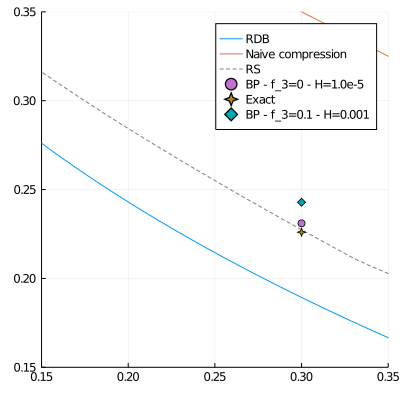

In [213]:
pl2 = deepcopy(pl)
scatter!(pl2, [R], [dist2], marker=:diamond, label="BP - f_3=$(round(r,digits=1)) - H=$H")
plot(pl2, size=(400,400))
xlims!((0.15,0.35)); ylims!((0.15,0.35))

### 2.1 Varying H

In [31]:
m = factorial(5)*11
R = 0.8/3
r = 1 - 3R
n = round(Int, 3m/(2+r))
Λ = OffsetVector([0,0,1-r,r], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
nedges = 3m
lambda, rho = nodes2edges(Λ[1:end], K[1:end])
Hs3 = 10.0 .^ (-5:1:-1)
# Hs3 = 0.01:1:5.01
navg = 20
dist_f3 = [Float64[] for _ in eachindex(Hs3)]
for j in 1:navg
    println("#### Round $j of $navg")
    fg = ldpc_graphGF2(n,m,nedges,lambda,rho)
    _, freevars = findbasis_slow(Array(fg.H))
    s = rand((-1,1), n)
    for (i,H) in enumerate(Hs3)
        println("------ H=", H, ". ", i, " of ", length(Hs3), " ------")
        fields = tanh.(H*copy(s))
        _,_,d = decimate!(fg, fields, freevars, maxiter=2000, Tmax=10, verbose=false, tol=1e-12) 
        isnan(d) || push!(dist_f3[i], d) 
    end
end

#### Round 1 of 20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


------ H=1.0e-5. 1 of 5 ------
# Trial 1 of 10: 1 unsat
# Trial 2 of 10: 1 unsat
# Trial 3 of 10: 1 unsat
# Trial 4 of 10: 1 unsat
# Trial 5 of 10: 1 unsat
# Trial 6 of 10: 1 unsat
# Trial 7 of 10: 1 unsat
# Trial 8 of 10: 1 unsat
# Trial 9 of 10: 1 unsat
# Trial 10 of 10: 1 unsat
No zero-unsat found after 10 trials
------ H=0.0001. 2 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.001. 3 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.01. 4 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.1. 5 of 5 ------
# Trial 1 of 10: 1 unsat
# Trial 2 of 10: 1 unsat
# Trial 3 of 10: 1 unsat
# Trial 4 of 10: 1 unsat
# Trial 5 of 10: 1 unsat
# Trial 6 of 10: 1 unsat
# Trial 7 of 10: 1 unsat
# Trial 8 of 10: 1 unsat
# Trial 9 of 10: 1 unsat
# Trial 10 of 10: 1 unsat
No zero-unsat found after 10 trials
#### Round 2 of 20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


------ H=1.0e-5. 1 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.0001. 2 of 5 ------
# Trial 1 of 10: 1 unsat
# Trial 2 of 10: 1 unsat
# Trial 3 of 10: 1 unsat
# Trial 4 of 10: 1 unsat
# Trial 5 of 10: 1 unsat
# Trial 6 of 10: 1 unsat
# Trial 7 of 10: 1 unsat
# Trial 8 of 10: 1 unsat
# Trial 9 of 10: 1 unsat
# Trial 10 of 10: 1 unsat
No zero-unsat found after 10 trials
------ H=0.001. 3 of 5 ------
# Trial 1 of 10: 1 unsat
# Trial 2 of 10: 1 unsat
# Trial 3 of 10: 1 unsat
# Trial 4 of 10: 1 unsat
# Trial 5 of 10: 1 unsat
# Trial 6 of 10: 1 unsat
# Trial 7 of 10: 1 unsat
# Trial 8 of 10: 1 unsat
# Trial 9 of 10: 1 unsat
# Trial 10 of 10: 1 unsat
No zero-unsat found after 10 trials
------ H=0.01. 4 of 5 ------
# Trial 1 of 10: 1 unsat
# Trial 2 of 10: 1 unsat
# Trial 3 of 10: 1 unsat
# Trial 4 of 10: 1 unsat
# Trial 5 of 10: 1 unsat
# Trial 6 of 10: 1 unsat
# Trial 7 of 10: 1 unsat
# Trial 8 of 10: 1 unsat
# Trial 9 of 10: 1 unsat
# Trial 10 of 10: 1 unsat
No zero-unsat found after 10 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


------ H=1.0e-5. 1 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.0001. 2 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.001. 3 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.01. 4 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.1. 5 of 5 ------
# Trial 1 of 10: 7 unsat
# Trial 2 of 10: 1 unsat
# Trial 3 of 10: 1 unsat
# Trial 4 of 10: 4 unsat
# Trial 5 of 10: 5 unsat
# Trial 6 of 10: 1 unsat
# Trial 7 of 10: 2 unsat
# Trial 8 of 10: 4 unsat
# Trial 9 of 10: 1 unsat
# Trial 10 of 10: 1 unsat
No zero-unsat found after 10 trials
#### Round 4 of 20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


------ H=1.0e-5. 1 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.0001. 2 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.001. 3 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.01. 4 of 5 ------
# Trial 1 of 10: contradiction found after 362 iters
# Trial 2 of 10: contradiction found after 364 iters
# Trial 3 of 10: contradiction found after 362 iters
# Trial 4 of 10: contradiction found after 361 iters
# Trial 5 of 10: contradiction found after 363 iters
# Trial 6 of 10: contradiction found after 362 iters
# Trial 7 of 10: contradiction found after 360 iters
# Trial 8 of 10: contradiction found after 355 iters
# Trial 9 of 10: contradiction found after 360 iters
# Trial 10 of 10: contradiction found after 355 iters
No zero-unsat found after 10 trials
------ H=0.1. 5 of 5 ------
# Trial 1 of 10: 5 unsat
# Trial 2 of 10: 6 unsat
# Trial 3 of 10: contradiction found after 812 iters
# Trial 4 of 10: 7 unsat
# Trial 5 of 10: 4 unsat
# Trial 6 of 10: 10 unsat
# Trial 7 of 10: 3 unsat
# Tri

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


------ H=1.0e-5. 1 of 5 ------
# Trial 1 of 10: 1 unsat
# Trial 2 of 10: 1 unsat
# Trial 3 of 10: 1 unsat
# Trial 4 of 10: 1 unsat
# Trial 5 of 10: 1 unsat
# Trial 6 of 10: 1 unsat
# Trial 7 of 10: 1 unsat
# Trial 8 of 10: 1 unsat
# Trial 9 of 10: 1 unsat
# Trial 10 of 10: 1 unsat
No zero-unsat found after 10 trials
------ H=0.0001. 2 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.001. 3 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.01. 4 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.1. 5 of 5 ------
# Trial 1 of 10: 6 unsat
# Trial 2 of 10: 1 unsat
# Trial 3 of 10: 2 unsat
# Trial 4 of 10: 1 unsat
# Trial 5 of 10: 2 unsat
# Trial 6 of 10: 2 unsat
# Trial 7 of 10: 1 unsat
# Trial 8 of 10: 3 unsat
# Trial 9 of 10: 4 unsat
# Trial 10 of 10: 4 unsat
No zero-unsat found after 10 trials
#### Round 6 of 20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


------ H=1.0e-5. 1 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.0001. 2 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.001. 3 of 5 ------
# Trial 1 of 10: 1 unsat
# Trial 2 of 10: 1 unsat
# Trial 3 of 10: 1 unsat
# Trial 4 of 10: 1 unsat
# Trial 5 of 10: 1 unsat
# Trial 6 of 10: 1 unsat
# Trial 7 of 10: 1 unsat
# Trial 8 of 10: 1 unsat
# Trial 9 of 10: 1 unsat
# Trial 10 of 10: 1 unsat
No zero-unsat found after 10 trials
------ H=0.01. 4 of 5 ------
# Trial 1 of 10: 1 unsat
# Trial 2 of 10: 1 unsat
# Trial 3 of 10: 1 unsat
# Trial 4 of 10: 1 unsat
# Trial 5 of 10: 1 unsat
# Trial 6 of 10: 1 unsat
# Trial 7 of 10: 1 unsat
# Trial 8 of 10: 1 unsat
# Trial 9 of 10: 1 unsat
# Trial 10 of 10: 1 unsat
No zero-unsat found after 10 trials
------ H=0.1. 5 of 5 ------
# Trial 1 of 10: 1 unsat
# Trial 2 of 10: 1 unsat
# Trial 3 of 10: 1 unsat
# Trial 4 of 10: 1 unsat
# Trial 5 of 10: 1 unsat
# Trial 6 of 10: 1 unsat
# Trial 7 of 10: 1 unsat
# Trial 8 of 10: 1 unsat
# Trial 9 of 10: 1 unsat
# 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


------ H=1.0e-5. 1 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.0001. 2 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.001. 3 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.01. 4 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.1. 5 of 5 ------
# Trial 1 of 10: 0 unsat
#### Round 8 of 20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


------ H=1.0e-5. 1 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.0001. 2 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.001. 3 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.01. 4 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.1. 5 of 5 ------
# Trial 1 of 10: 0 unsat
#### Round 9 of 20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


------ H=1.0e-5. 1 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.0001. 2 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.001. 3 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.01. 4 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.1. 5 of 5 ------
# Trial 1 of 10: 0 unsat
#### Round 10 of 20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


------ H=1.0e-5. 1 of 5 ------
# Trial 1 of 10: 1 unsat
# Trial 2 of 10: 1 unsat
# Trial 3 of 10: 1 unsat
# Trial 4 of 10: 1 unsat
# Trial 5 of 10: 1 unsat
# Trial 6 of 10: 1 unsat
# Trial 7 of 10: 1 unsat
# Trial 8 of 10: 1 unsat
# Trial 9 of 10: 1 unsat
# Trial 10 of 10: 1 unsat
No zero-unsat found after 10 trials
------ H=0.0001. 2 of 5 ------
# Trial 1 of 10: 1 unsat
# Trial 2 of 10: 1 unsat
# Trial 3 of 10: 1 unsat
# Trial 4 of 10: 1 unsat
# Trial 5 of 10: 1 unsat
# Trial 6 of 10: 1 unsat
# Trial 7 of 10: 1 unsat
# Trial 8 of 10: 1 unsat
# Trial 9 of 10: 1 unsat
# Trial 10 of 10: 1 unsat
No zero-unsat found after 10 trials
------ H=0.001. 3 of 5 ------
# Trial 1 of 10: 1 unsat
# Trial 2 of 10: 1 unsat
# Trial 3 of 10: 1 unsat
# Trial 4 of 10: 1 unsat
# Trial 5 of 10: 1 unsat
# Trial 6 of 10: 1 unsat
# Trial 7 of 10: 1 unsat
# Trial 8 of 10: 1 unsat
# Trial 9 of 10: 1 unsat
# Trial 10 of 10: 1 unsat
No zero-unsat found after 10 trials
------ H=0.01. 4 of 5 ------
# Trial 1 of 10: 1

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


------ H=1.0e-5. 1 of 5 ------
# Trial 1 of 10: 1 unsat
# Trial 2 of 10: 0 unsat
------ H=0.0001. 2 of 5 ------
# Trial 1 of 10: 1 unsat
# Trial 2 of 10: 1 unsat
# Trial 3 of 10: 1 unsat
# Trial 4 of 10: 1 unsat
# Trial 5 of 10: 1 unsat
# Trial 6 of 10: 1 unsat
# Trial 7 of 10: 1 unsat
# Trial 8 of 10: 1 unsat
# Trial 9 of 10: 1 unsat
# Trial 10 of 10: 1 unsat
No zero-unsat found after 10 trials
------ H=0.001. 3 of 5 ------
# Trial 1 of 10: 1 unsat
# Trial 2 of 10: 1 unsat
# Trial 3 of 10: 1 unsat
# Trial 4 of 10: 1 unsat
# Trial 5 of 10: 1 unsat
# Trial 6 of 10: 1 unsat
# Trial 7 of 10: 1 unsat
# Trial 8 of 10: 1 unsat
# Trial 9 of 10: 1 unsat
# Trial 10 of 10: 1 unsat
No zero-unsat found after 10 trials
------ H=0.01. 4 of 5 ------
# Trial 1 of 10: 1 unsat
# Trial 2 of 10: 1 unsat
# Trial 3 of 10: 1 unsat
# Trial 4 of 10: 1 unsat
# Trial 5 of 10: 1 unsat
# Trial 6 of 10: 1 unsat
# Trial 7 of 10: 1 unsat
# Trial 8 of 10: 1 unsat
# Trial 9 of 10: 1 unsat
# Trial 10 of 10: 1 unsat
No z

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


------ H=1.0e-5. 1 of 5 ------
# Trial 1 of 10: 1 unsat
# Trial 2 of 10: 1 unsat
# Trial 3 of 10: 1 unsat
# Trial 4 of 10: 1 unsat
# Trial 5 of 10: 1 unsat
# Trial 6 of 10: 1 unsat
# Trial 7 of 10: 1 unsat
# Trial 8 of 10: 1 unsat
# Trial 9 of 10: 1 unsat
# Trial 10 of 10: 1 unsat
No zero-unsat found after 10 trials
------ H=0.0001. 2 of 5 ------
# Trial 1 of 10: 1 unsat
# Trial 2 of 10: 1 unsat
# Trial 3 of 10: 1 unsat
# Trial 4 of 10: 1 unsat
# Trial 5 of 10: 1 unsat
# Trial 6 of 10: 1 unsat
# Trial 7 of 10: 1 unsat
# Trial 8 of 10: 1 unsat
# Trial 9 of 10: 1 unsat
# Trial 10 of 10: 1 unsat
No zero-unsat found after 10 trials
------ H=0.001. 3 of 5 ------
# Trial 1 of 10: 1 unsat
# Trial 2 of 10: 1 unsat
# Trial 3 of 10: 1 unsat
# Trial 4 of 10: 1 unsat
# Trial 5 of 10: 1 unsat
# Trial 6 of 10: 1 unsat
# Trial 7 of 10: 1 unsat
# Trial 8 of 10: 1 unsat
# Trial 9 of 10: 1 unsat
# Trial 10 of 10: 1 unsat
No zero-unsat found after 10 trials
------ H=0.01. 4 of 5 ------
# Trial 1 of 10: 1

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


------ H=1.0e-5. 1 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.0001. 2 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.001. 3 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.01. 4 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.1. 5 of 5 ------
# Trial 1 of 10: 0 unsat
#### Round 14 of 20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


------ H=1.0e-5. 1 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.0001. 2 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.001. 3 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.01. 4 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.1. 5 of 5 ------
# Trial 1 of 10: 0 unsat
#### Round 15 of 20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


------ H=1.0e-5. 1 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.0001. 2 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.001. 3 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.01. 4 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.1. 5 of 5 ------
# Trial 1 of 10: contradiction found after 1209 iters
# Trial 2 of 10: contradiction found after 592 iters
# Trial 3 of 10: 6 unsat
# Trial 4 of 10: 1 unsat
# Trial 5 of 10: contradiction found after 1251 iters
# Trial 6 of 10: contradiction found after 944 iters
# Trial 7 of 10: 7 unsat
# Trial 8 of 10: contradiction found after 583 iters
# Trial 9 of 10: contradiction found after 1503 iters
# Trial 10 of 10: contradiction found after 1272 iters
No zero-unsat found after 10 trials
#### Round 16 of 20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


------ H=1.0e-5. 1 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.0001. 2 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.001. 3 of 5 ------
# Trial 1 of 10: 1 unsat
# Trial 2 of 10: 1 unsat
# Trial 3 of 10: 1 unsat
# Trial 4 of 10: 1 unsat
# Trial 5 of 10: 1 unsat
# Trial 6 of 10: 1 unsat
# Trial 7 of 10: 1 unsat
# Trial 8 of 10: 1 unsat
# Trial 9 of 10: 1 unsat
# Trial 10 of 10: 1 unsat
No zero-unsat found after 10 trials
------ H=0.01. 4 of 5 ------
# Trial 1 of 10: 1 unsat
# Trial 2 of 10: 1 unsat
# Trial 3 of 10: 1 unsat
# Trial 4 of 10: 1 unsat
# Trial 5 of 10: 1 unsat
# Trial 6 of 10: 1 unsat
# Trial 7 of 10: 1 unsat
# Trial 8 of 10: 1 unsat
# Trial 9 of 10: 1 unsat
# Trial 10 of 10: 1 unsat
No zero-unsat found after 10 trials
------ H=0.1. 5 of 5 ------
# Trial 1 of 10: 7 unsat
# Trial 2 of 10: 1 unsat
# Trial 3 of 10: 1 unsat
# Trial 4 of 10: 3 unsat
# Trial 5 of 10: 6 unsat
# Trial 6 of 10: 4 unsat
# Trial 7 of 10: 1 unsat
# Trial 8 of 10: 2 unsat
# Trial 9 of 10: 1 unsat
# 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


------ H=1.0e-5. 1 of 5 ------
# Trial 1 of 10: 1 unsat
# Trial 2 of 10: 1 unsat
# Trial 3 of 10: 1 unsat
# Trial 4 of 10: 1 unsat
# Trial 5 of 10: 1 unsat
# Trial 6 of 10: 1 unsat
# Trial 7 of 10: 1 unsat
# Trial 8 of 10: 1 unsat
# Trial 9 of 10: 1 unsat
# Trial 10 of 10: 1 unsat
No zero-unsat found after 10 trials
------ H=0.0001. 2 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.001. 3 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.01. 4 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.1. 5 of 5 ------
# Trial 1 of 10: 1 unsat
# Trial 2 of 10: 1 unsat
# Trial 3 of 10: 1 unsat
# Trial 4 of 10: 1 unsat
# Trial 5 of 10: 1 unsat
# Trial 6 of 10: 1 unsat
# Trial 7 of 10: 1 unsat
# Trial 8 of 10: 1 unsat
# Trial 9 of 10: 1 unsat
# Trial 10 of 10: 1 unsat
No zero-unsat found after 10 trials
#### Round 18 of 20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


------ H=1.0e-5. 1 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.0001. 2 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.001. 3 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.01. 4 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.1. 5 of 5 ------
# Trial 1 of 10: 0 unsat
#### Round 19 of 20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


------ H=1.0e-5. 1 of 5 ------
# Trial 1 of 10: 1 unsat
# Trial 2 of 10: 1 unsat
# Trial 3 of 10: 1 unsat
# Trial 4 of 10: 1 unsat
# Trial 5 of 10: 1 unsat
# Trial 6 of 10: 1 unsat
# Trial 7 of 10: 1 unsat
# Trial 8 of 10: 1 unsat
# Trial 9 of 10: 1 unsat
# Trial 10 of 10: 1 unsat
No zero-unsat found after 10 trials
------ H=0.0001. 2 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.001. 3 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.01. 4 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.1. 5 of 5 ------
# Trial 1 of 10: 0 unsat
#### Round 20 of 20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


------ H=1.0e-5. 1 of 5 ------
# Trial 1 of 10: 0 unsat
------ H=0.0001. 2 of 5 ------
# Trial 1 of 10: 1 unsat
# Trial 2 of 10: 1 unsat
# Trial 3 of 10: 1 unsat
# Trial 4 of 10: 1 unsat
# Trial 5 of 10: 1 unsat
# Trial 6 of 10: 1 unsat
# Trial 7 of 10: 1 unsat
# Trial 8 of 10: 1 unsat
# Trial 9 of 10: 1 unsat
# Trial 10 of 10: 1 unsat
No zero-unsat found after 10 trials
------ H=0.001. 3 of 5 ------
# Trial 1 of 10: 1 unsat
# Trial 2 of 10: 1 unsat
# Trial 3 of 10: 1 unsat
# Trial 4 of 10: 1 unsat
# Trial 5 of 10: 1 unsat
# Trial 6 of 10: 1 unsat
# Trial 7 of 10: 1 unsat
# Trial 8 of 10: 1 unsat
# Trial 9 of 10: 1 unsat
# Trial 10 of 10: 1 unsat
No zero-unsat found after 10 trials
------ H=0.01. 4 of 5 ------
# Trial 1 of 10: 1 unsat
# Trial 2 of 10: 1 unsat
# Trial 3 of 10: 1 unsat
# Trial 4 of 10: 1 unsat
# Trial 5 of 10: 1 unsat
# Trial 6 of 10: 1 unsat
# Trial 7 of 10: 1 unsat
# Trial 8 of 10: 1 unsat
# Trial 9 of 10: 1 unsat
# Trial 10 of 10: 1 unsat
No zero-unsat found after 10 

In [ ]:
println("Avg over $navg instances")
colors = cgrad(:heat, length(Hs3)+1, categorical = true)
pl_f3 = plot_rdb()
for (i,H) in enumerate(Hs3)
    scatter!(pl_f3, [R], [mean(dist_f3[i])], 
        yerr = [std(dist_f3[i])/sqrt(length(dist_f3[i]))],
        label="BP - f_3=$(round(r,digits=1)) - H=$(round(H,sigdigits=2))", mc=colors[i], ms=3)
end
plot(pl_f3, size=(500,300), legend=:topright)
xlims!((0.15,0.35)); ylims!((0.22,0.25))

In [21]:
mean.(dist_f3)

5-element Array{Float64,1}:
 0.23834834834834834
 0.23824845679012346
 0.23862268518518523
 0.2385503472222222
 0.23484195402298852

In [178]:
send_notif()

In [25]:
n

14400